# Chapter 2 - Programming Probabilistiaclly 
### Chapter code rundown and exercises

In [ ]:
# Prepare modules:
import numpy as np 
from scipy import stats
import pymc3 as pm
import arviz as az
import theano
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Coin flip example data
np.random.seed(123)
trials = 4
theta_real = 0.35 #unknown value in real experiment
data = stats.bernoulli.rvs(p = theta_real, size = trials)

In [ ]:
#Specify model
with pm.Model() as our_first_model: # creates a container for our model
    theta = pm.Beta("theta", alpha =1., beta = 1.) #specifies the prior
    y = pm.Bernoulli("y", p = theta, observed = data) #specifies the likelihood
    trace = pm.sample(1000, random_seed=123) #Extract 1,000 samples from the posterior and store them in the trace object

In [ ]:
az.plot_trace(trace) # see results of sampling from posterior

In [ ]:
az.summary(trace)

In [ ]:
az.plot_posterior(trace)

In [ ]:
az.plot_posterior(trace, rope=[0.45, .55], ref_val=0.5) #ROPE = Region of practical Equivolance

### Loss functions:

In [ ]:
grid = np.linspace(0, 1, 200)
theta_pos = trace['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [ ]:
data = np.loadtxt('../data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

In [ ]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

In [ ]:
#Bi-dimensional posterior
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [155]:
#Summary:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.492,0.519,52.569,54.525,0.010,0.007,2952.0,2952.0,2968.0,2420.0,1.0
σ,3.546,0.379,2.860,4.240,0.007,0.005,3047.0,2830.0,3425.0,2462.0,1.0


In [ ]:
#Posterior oredictive checks (PPCs)
#generate 100 predictions from the posterior, each one of the same siza as the data
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

#Plot
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)


### Now Try with a students-t

In [ ]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

In [154]:
az.summary(trace_t)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.022,0.396,52.307,53.783,0.007,0.005,2857.0,2855.0,2855.0,2595.0,1.0
σ,2.194,0.408,1.482,2.979,0.009,0.007,1961.0,1957.0,1977.0,1879.0,1.0
ν,4.578,3.846,1.072,9.305,0.095,0.067,1629.0,1629.0,2102.0,1746.0,1.0


#### Posterior predictive checks (For students-t)

In [ ]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
plt.legend(fontsize=15)
plt.xlim(40, 70)

### Tips dataset example (Cohen's d and probability of superiority)

In [ ]:
#Load data
tips = pd.read_csv('../data/tips.csv')
tips.head()

In [ ]:
sns.violinplot(x='day', y='tip', data=tips)

In [ ]:
#Prep data
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
    categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [ ]:
#Define model
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

In [ ]:
#Mega plot
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]
for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 +trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}",
    alpha=0)
    ax[k, l].legend()

### Water test example (Hierarchical models)

In [ ]:
#Simulate data
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]- G_samples[i]]))

In [ ]:
#Define model
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_h = pm.sample(2000)


In [ ]:
az.plot_trace(trace_h, legend=True)

In [ ]:
az.summary(trace_h)

# Exercises

## Exercise 1
Using PyMC3, change the parameters of the prior beta distribution
in our_first_model to match those of the previous chapter. Compare the
results to the previous chapter. Replace the beta distribution with a uniform one
in the interval [[0,1]]. Are the results equivalent to the Beta($\alpha$=1,$\beta$=1)? Is the
sampling slower, faster, or the same? What about using a larger interval such as
[[-1, 2]]? Does the model run? What errors do you get?

In [ ]:
import time
t0 = time.time()

#Base model
with pm.Model() as our_first_model: 
    theta = pm.Beta("theta", alpha =1., beta = 1.) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace1 = pm.sample(1000, random_seed=123) 
    first_rt = time.time()-t0

t0 = time.time()
#new model1
with pm.Model() as our_second_model: 
    theta = pm.Uniform("theta" , lower = 0, upper = 1 ) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace2 = pm.sample(1000, random_seed=123) 
    second_rt = time.time()-t0

t0 = time.time()
#New model2
with pm.Model() as our_third_model: 
    theta = pm.Uniform("theta" , lower = -1, upper = 2 ) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace3 = pm.sample(1000, random_seed=123)
    third_rt = time.time()-t0 

print("\n Model runtimes: \n", first_rt,  second_rt,  third_rt)

In [ ]:
az.summary(trace3)

## Exercise 2

Read about the coal mining disaster model that is part of the PyMC3
documentation: http:/​/​pymc-​devs.​github.​io/​pymc3/​notebooks/​getting_
started.​html#Case-​study-​2:-​Coal-​mining-​disasters. Try to implement and
run this model by yourself.

In [ ]:
#Prep data
import pandas as pd

disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

years = np.arange(1851, 1962)



In [ ]:
#Good luck doing this without the tutorial:
with pm.Model() as disaster_model: #initiate model

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    ) # Discrete uniform prior that switches at 1900

    # Priors for pre- and post-switch rates number of disasters (i.e. later than 1900 - switchy boi go switch)
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

In [ ]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

In [ ]:
az.summary(trace)

## Exercise 3

Modify model_g, change the prior for the mean to a Gaussian distribution
centered at the empirical mean, and play with a couple of reasonable values for
the standard deviation of this prior. How robust/sensitive are the inferences to
these changes? What do you think of using a Gaussian, which is an unbounded
distribution (goes from -∞ to ∞), to model bounded data such as this? Remember
that we said it is not possible to get values below 0 or above 100.

In [146]:
data = np.loadtxt('../data/chemical_shifts.csv')

with pm.Model() as model_g:
    μ = pm.Normal('μ', mu = data.mean(), sd = 10 )
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu = μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.497,0.454,52.619,54.286,0.007,0.005,3795.0,3795.0,3793.0,3111.0,1.0
σ,3.543,0.387,2.858,4.279,0.006,0.005,3729.0,3650.0,3789.0,2693.0,1.0


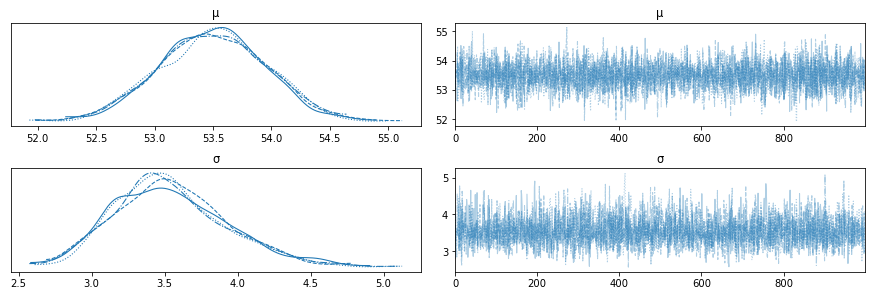

In [145]:
az.plot_trace(trace_g)
az.summary(trace_g)

## Exercise 4

Using the data in the chemical_shifts.csv file, compute the empirical mean
and the standard deviation with and without outliers. Compare those results to
the Bayesian estimation using the Gaussian and Student's t-distribution. Repeat
the exercise by adding more outliers.

In [151]:
#Load data and build outlier rejection
data = np.loadtxt('../data/chemical_shifts.csv')
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


#With outliers:
mean_all = data.mean()
sd_all = data.std()

#Without outliers: 
data_clean = reject_outliers(data,m=2)
mean_out = data_clean.mean()
sd_out = data_clean.std()


In [152]:
#See dem numbers
print(mean_all, mean_out)
print(sd_all, sd_out)

53.49645833333333 52.95260869565218
3.4200063898474258 2.1950303897892387


## Exercise 5

## Exercise 6

## Exercise 7

## Exercise 8

## Exercise 9